## McKinsey Hackathon on Stroke Probability Prediction

***A Solution by Aparna C Shastry ***

Dated April 14-15th GMT 00:00 (24 hr duration hackathon)

[GitHub](https://github.com/aparnack/data_science)       
[twitter](https://twitter.com/aparsha2303)         
[LinkedIn](https://www.linkedin.com/in/aparnacshastry/)        
[Email](mailto:aparnashastrymls@gmail.com)


### Problem Statement
Your Client, a chain of hospitals aiming to create the next generation of healthcare for its patients, has retained McKinsey to help achieve its vision. The company brings the best doctors and enables them to provide proactive health care for its patients. One such investment is a Center of Data Science Excellence.

 

In this case, your client wants to have study around one of the critical disease "Stroke". Stroke is a disease that affects the arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or bursts (or ruptures). When that happens, part of the brain cannot get the blood (and oxygen) it needs, so it and brain cells die.

 

Over the last few years, the Client has captured several health, demographic and lifestyle details about its patients. This includes details such as age and gender, along with several health parameters (e.g. hypertension, body mass index) and lifestyle related variables (e.g. smoking status, occupation type).

 

The Client wants you to predict the probability of stroke happening to their patients. This will help doctors take proactive health measures for these patients.

### Evaluation Metric

It is AUC-ROC

### Public and Private Split
Test data is further randomly divided into Public (30%) and Private (70%) data.

+ Your initial responses will be checked and scored on the Public data.
+ The final rankings would be based on your private score which will be published once the competition is over.

## Solution

Before doing any coding, let us understand the problem. 
+ [This](https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113) an article I read from mayoclinic on stroke, risk factors, lifestyle factors affecting etc. This article covers most features present in this dataset, such as age, gender, hypertension, heart disease, glucose level(article talks diabetes), bmi(article talks about overweight/obese) and smoking status. I will be generating some more new features based on this.
+ We should examine, ever_married, residence type, work type separately. Work type is partially addressed above because it says exercising reduces the risk of stroke. However, we do not have sufficient info in the work type to conclude whether work includes physical exercise or not.
+ ever_married: Although not from reliable source, I found [this](https://www.today.com/health/odds-surviving-after-stroke-better-if-you-re-married-t106002) article on odds of survival after stroke if you are married. But commonsense says that being married might motivate one to keep a better lifestyle But still this seems like a weak feature.
+ residence type: There is no medical evidence on this. This may not have direct impact on stroke, but might help in imputation of missing values
+ work type: never worked might mean lack of exercise? Can not say. We need to see how it can be used later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 7
import time
import statsmodels.api as sm

C:\Users\Aparn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('train_ajEneEa.csv')
test = pd.read_csv('test_v2akXPA.csv')

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


BMI and smoking status have missing values

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18601 entries, 0 to 18600
Data columns (total 11 columns):
id                   18601 non-null int64
gender               18601 non-null object
age                  18601 non-null float64
hypertension         18601 non-null int64
heart_disease        18601 non-null int64
ever_married         18601 non-null object
work_type            18601 non-null object
Residence_type       18601 non-null object
avg_glucose_level    18601 non-null float64
bmi                  18010 non-null float64
smoking_status       12850 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 1.6+ MB


In [6]:
train.nunique(), test.nunique()

(id                   43400
 gender                   3
 age                    104
 hypertension             2
 heart_disease            2
 ever_married             2
 work_type                5
 Residence_type           2
 avg_glucose_level    12543
 bmi                    555
 smoking_status           3
 stroke                   2
 dtype: int64, id                   18601
 gender                   3
 age                    104
 hypertension             2
 heart_disease            2
 ever_married             2
 work_type                5
 Residence_type           2
 avg_glucose_level     8744
 bmi                    500
 smoking_status           3
 dtype: int64)

In [7]:
print("Gender unique train and test:",train.gender.unique(),test.gender.unique())
print("Work type unique train and test:",train.work_type.unique(),test.work_type.unique())
print("Smoking status unique train and test:",train.smoking_status.unique(),test.smoking_status.unique())

Gender unique train and test: ['Male' 'Female' 'Other'] ['Male' 'Female' 'Other']
Work type unique train and test: ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job'] ['Private' 'Self-employed' 'children' 'Govt_job' 'Never_worked']
Smoking status unique train and test: [nan 'never smoked' 'formerly smoked' 'smokes'] ['formerly smoked' nan 'never smoked' 'smokes']


In [8]:
train.stroke.value_counts()/train.stroke.count()

0    0.981959
1    0.018041
Name: stroke, dtype: float64

In [9]:
test['stroke'] = 0

### 1. Data Cleaning and Exploratory Data Analysis

In [10]:
train['training_set'] = True #adding an extra variable to training and testing dataset before joining them, this will be removed
test['training_set'] = False  
data = pd.concat([train, test]) #concatenate both dataframes prior to EDA. I am still debating within myself if EDA should be done on both or only on Train
target = data['stroke']  #target variable
data = data.drop('stroke',axis=1)
df = data.copy()

In [11]:
# let's break down the columns by their type (i.e. int64, float64, object)
data.columns.to_series().groupby(data.dtypes).groups

{dtype('bool'): Index(['training_set'], dtype='object'),
 dtype('int64'): Index(['id', 'hypertension', 'heart_disease'], dtype='object'),
 dtype('float64'): Index(['age', 'avg_glucose_level', 'bmi'], dtype='object'),
 dtype('O'): Index(['gender', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status'],
       dtype='object')}

In [12]:
perc_na = (data.isnull().sum()/len(data))*100
ratio_na = perc_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :ratio_na})
missing_data

,Missing Ratio
smoking_status,30.714021
bmi,3.311237
training_set,0.000000
avg_glucose_level,0.000000
Residence_type,0.000000
work_type,0.000000
ever_married,0.000000
heart_disease,0.000000
hypertension,0.000000
age,0.000000


In [13]:
data.loc[data.age < 10,'smoking_status'] = 'never smoked'
train.loc[train.age < 10,'smoking_status'] = 'never smoked'
test.loc[test.age < 10,'smoking_status'] = 'never smoked'

count    59948.000000
mean        28.587099
std          7.766122
min         10.100000
25%         23.200000
50%         27.700000
75%         32.800000
max         97.600000
Name: bmi, dtype: float64

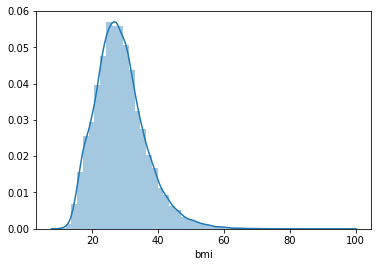

In [14]:
_ = sns.distplot(data.bmi.dropna())
data.bmi.describe()

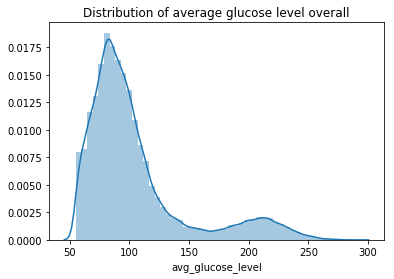

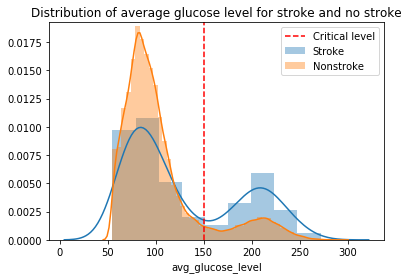

In [15]:
sns.distplot(train.avg_glucose_level)
plt.title('Distribution of average glucose level overall')
plt.figure()
sns.distplot(train[train.stroke==1].avg_glucose_level)
plt.title('Distribution of average glucose level for stroke and no stroke')
sns.distplot(train[train.stroke==0].avg_glucose_level)
plt.axvline(150,linestyle='--',color='r')
plt.legend(['Critical level','Stroke','Nonstroke'])

**First Plot**: Drawn to understand the overall distribution

**Second plot**   
Diabetese definition: Avg glucose level above 180 after 2 hours of meal is diabetese. In the plot above, it seems like after 150, the curves are diverging.
This is a distinguishing feature. It was worthwhile to think of making it more distinguishing by taking square and adding it as feature. It did not result in any improvement in public leaderboard score, hence found it risky to keep. 

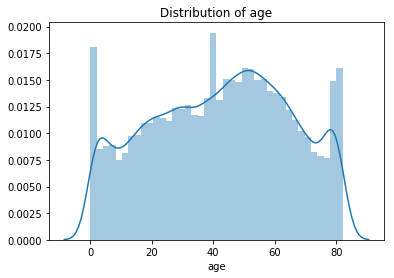

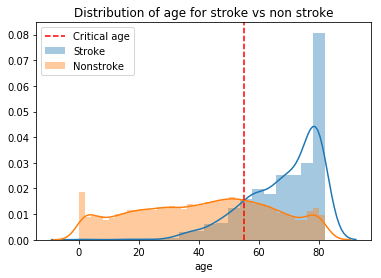

In [16]:
sns.distplot(train.age)
plt.title('Distribution of age')
plt.figure()
sns.distplot(train[train.stroke==1].age)
sns.distplot(train[train.stroke==0].age)
plt.axvline(55,linestyle='--',color='r')
plt.title('Distribution of age for stroke vs non stroke')
plt.legend(['Critical age','Stroke','Nonstroke'])

**First Plot**: Done to see the overall distribution of age in data set. Except spikes at age < 5, around 40 and at 70 and above, other ages are uniformly distributed more or less.

**Second Plot:** The mayoclinic article mentions that people above age 55 are at higher stroke risk and the point at which both distributions meet is exactly that!

The distributions have overlaps from 40 to 80. However, we are interested in probabilities and other features will help in distinguishing the two groups.

The odds of having stokes shoots up around age 70 to 80

In [17]:
print("Number of people below 30 who had stroke:",train.loc[train.age.isin(range(10,31)),:].groupby('stroke').id.count())
print("probability: ",1/9951)
train.loc[train.age.isin(range(10,31)),:].groupby('stroke').mean()

Number of people below 30 who had stroke: stroke
0    9948
1       3
Name: id, dtype: int64
probability:  0.00010049241282283188


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,training_set
stroke,,,,,,,
0,36368.488741,20.740450,0.006936,0.000503,93.640803,26.816101,True
1,53215.666667,21.333333,0.000000,0.000000,62.023333,28.300000,True


stroke  ever_married
0       Yes             21148
        No               2885
1       Yes               340
        No                 34
Name: ever_married, dtype: int64


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,training_set
stroke,,,,,,,
0,36564.294512,49.736612,0.112512,0.043315,107.016973,31.109426,True
1,37446.000000,58.371658,0.221925,0.192513,132.151658,31.743189,True


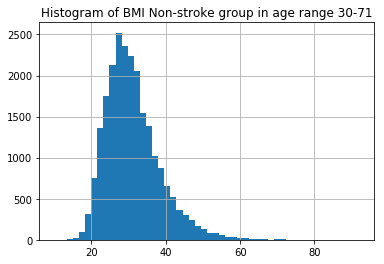

In [18]:
train.loc[(train.age.isin(range(30,71))) & (train['stroke']==0),'bmi'].hist(bins=50)
plt.title('Histogram of BMI Non-stroke group in age range 30-71')
print(train.loc[train.age.isin(range(30,71)),:].groupby('stroke').ever_married.value_counts())
train.loc[train.age.isin(range(30,71)),:].groupby('stroke').mean()

Number of people above who had stroke: stroke
0    4877
1     405
Name: id, dtype: int64


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,training_set
stroke,,,,,,,
0,36041.503178,76.879639,0.224728,0.171417,119.863664,28.862533,True
1,35978.864198,77.679012,0.288889,0.259259,127.856963,28.217353,True


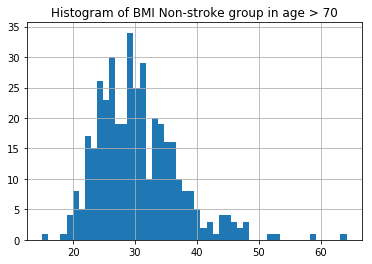

In [19]:
train.loc[(train.age.isin(range(70,71))) & (train['stroke']==0),'bmi'].hist(bins=50)
plt.title('Histogram of BMI Non-stroke group in age > 70')
print("Number of people above who had stroke:",train.loc[train.age > 70,:].groupby('stroke').id.count())
train.loc[train.age > 70,:].groupby('stroke').mean()

Note a few important points:
1. 405 out of total observed cases 783 i.e. more than 50% stroke come from this age range
2. All the stroke patients have more hypertension, heart disease and avg glucose level.

In [20]:
# let's list all the non-numerical columns from df_training
def conv_one_hot(data) :
    categorial_variables = data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
    print("The list of Categorical variables")
    print(list(categorial_variables))
    # Convert Categorical variables to dummies
    cat_var = pd.get_dummies(data[list(categorial_variables)],drop_first=True)
    # Remove originals
    data = data.drop(categorial_variables,axis=1)
    data = pd.concat([data,cat_var],axis=1)
    #removing dulpicate columns 
    _, i = np.unique(data.columns, return_index=True)  #Always better to have
    data=data.iloc[:, i] 
    return data

In [21]:
data = conv_one_hot(data)
data.head()

The list of Categorical variables
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


,Residence_type_Urban,age,avg_glucose_level,bmi,ever_married_Yes,gender_Male,gender_Other,heart_disease,hypertension,id,smoking_status_never smoked,smoking_status_smokes,training_set,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0,3.0,95.12,18.0,0,1,0,0,0,30669,1,0,True,0,0,0,1
1,1,58.0,87.96,39.2,1,1,0,0,1,30468,1,0,True,0,1,0,0
2,1,8.0,110.89,17.6,0,0,0,0,0,16523,1,0,True,0,1,0,0
3,0,70.0,69.04,35.9,1,0,0,0,0,56543,0,0,True,0,1,0,0
4,0,14.0,161.28,19.1,0,1,0,0,0,46136,0,0,True,1,0,0,0


In [22]:
perc_na = (data.isnull().sum()/len(data))*100
ratio_na = perc_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :ratio_na})
missing_data

,Missing Ratio
bmi,3.311237
work_type_children,0.000000
heart_disease,0.000000
age,0.000000
avg_glucose_level,0.000000
ever_married_Yes,0.000000
gender_Male,0.000000
gender_Other,0.000000
hypertension,0.000000
work_type_Self-employed,0.000000


NaN in smoking have disappeared due to one hot encoding
How to fill missing values in BMI? For that let us see the distribution

In [23]:
# Generate two features
data['male_children'] = data['gender_Male'] * data['work_type_children']
data['former_smoker'] = 0
data.loc[df['smoking_status']=='formerly smoked','former_smoker'] = 1
data['heart_dis_smoke'] = data['heart_disease'] & (data['smoking_status_smokes'] | data['former_smoker'])
data['hyp_tension_smoke'] = data['hypertension'] & (data['smoking_status_smokes'] | data['former_smoker'])

In [24]:
missing_bmi_rows = data[data.bmi.isnull()]
missing_bmi_rows.head()

,Residence_type_Urban,age,avg_glucose_level,bmi,ever_married_Yes,gender_Male,gender_Other,heart_disease,hypertension,id,...,smoking_status_smokes,training_set,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,male_children,former_smoker,heart_dis_smoke,hyp_tension_smoke
81,0,61.0,202.21,NaN,1,0,0,0,0,51676,...,0,True,0,0,1,0,0,0,0,0
95,1,34.0,106.23,NaN,1,1,0,1,0,31091,...,0,True,0,1,0,0,0,1,1,0
113,1,76.0,209.58,NaN,1,0,0,0,1,54312,...,0,True,0,0,1,0,0,0,0,0
186,0,63.0,79.92,NaN,1,0,0,0,0,11999,...,1,True,0,0,0,0,0,0,0,0
231,1,61.0,184.15,NaN,1,1,0,0,0,22470,...,0,True,0,0,0,0,0,0,0,0


In [25]:
# Check correlation of bmi with avg glucose level
valid_rows = data[~data.bmi.isnull()]
y = valid_rows['bmi']
valid_rows1 = valid_rows.drop(['bmi','training_set'],axis=1)
valid_rows1 = sm.add_constant(valid_rows1)
m = sm.OLS(y,valid_rows1)
res = m.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:40:43   Log-Likelihood:            -1.9929e+05
No. Observations:               59948   AIC:                         3.986e+05
Df Residuals:                   59928   BIC:                         3.988e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          26.7535      0.150    178.278      0.000      26.459      27.048
Residence_type_Urban           -0.0672      0.055     -1.223      0.221      -0.175       0.040
age                            -0.0046      0.002     -2.181      0.029      -0.009      -0.000
avg_glucose_level               0.0233      0.001     34.312      0.000       0.022       0.025
ever_married_Yes                1.7367      0.081     21.374      0.000       1.577       1.896
gender_Male                     0.1201      0.062      1.951      0.051      -0.001       0.241
gender_Other                    0.2820      2.378      0.119      0.906      -4.379       4.943
heart_disease                  -0.4768      0.202     -2.364      0.018      -0.872      -0.082
hypertension                    2.7875      0.133     20.961      0.000       2.527       3.048
id                          -7.317e-08   1.31e-06     -0.056      0.956   -2.65e-06     2.5e-06
smoking_status_never smoked    -0.3402      0.073     -4.649      0.000      -0.484      -0.197
smoking_status_smokes          -0.2216      0.097     -2.285      0.022      -0.412      -0.032
work_type_Never_worked         -2.7813      0.436     -6.380      0.000      -3.636      -1.927
work_type_Private              -0.3247      0.086     -3.761      0.000      -0.494      -0.156
work_type_Self-employed        -0.7236      0.106     -6.802      0.000      -0.932      -0.515
work_type_children             -8.7777      0.153    -57.382      0.000      -9.077      -8.478
male_children                   0.0095      0.157      0.060      0.952      -0.299       0.318
former_smoker                   0.5139      0.095      5.392      0.000       0.327       0.701
heart_dis_smoke                 0.1121      0.274      0.409      0.683      -0.425       0.650
hyp_tension_smoke              -1.3779      0.200     -6.879      0.000      -1.770      -0.985
==============================================================================
Omnibus:                    14523.158   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44404.113
Skew:                           1.250   Prob(JB):                         0.00
Kurtosis:                       6.396   Cond. No.                     3.68e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
missing = sm.add_constant(missing_bmi_rows)
missing = missing.drop(['bmi','training_set'],axis=1)
missing['bmi'] = res.predict(missing)

In [27]:
data.loc[data.bmi.isnull(),'bmi'] = missing['bmi']
df.loc[df.bmi.isnull(),'bmi'] = missing['bmi']

count    62001.000000
mean        28.652015
std          7.667106
min         10.100000
25%         23.400000
50%         28.000000
75%         32.800000
max         97.600000
Name: bmi, dtype: float64

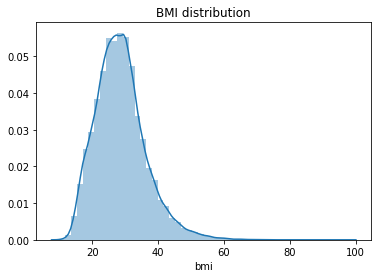

In [28]:
_ = sns.distplot(data.bmi)
_ = plt.title('BMI distribution')
data.bmi.describe()

**Correlations**

In [29]:
valid_rows['bmi'].corr(valid_rows['avg_glucose_level']),valid_rows['bmi'].corr(valid_rows['age'])

(0.19279240836754266, 0.3611044823478155)

** Some numerical EDAs to quench my curiosity**

In [30]:
data[data['gender_Male'] == 1].mean()

Residence_type_Urban               0.500867
age                               41.466429
avg_glucose_level                106.306582
bmi                               28.442170
ever_married_Yes                   0.624024
gender_Male                        1.000000
gender_Other                       0.000000
heart_disease                      0.069384
hypertension                       0.101120
id                             36418.997280
smoking_status_never smoked        0.433888
smoking_status_smokes              0.162383
training_set                       0.698731
work_type_Never_worked             0.003903
work_type_Private                  0.542734
work_type_Self-employed            0.154577
work_type_children                 0.178310
male_children                      0.178310
former_smoker                      0.190807
heart_dis_smoke                    0.039659
hyp_tension_smoke                  0.049949
dtype: float64

In [31]:
train.groupby('gender').stroke.value_counts()

gender  stroke
Female  0         25234
        1           431
Male    0         17372
        1           352
Other   0            11
Name: stroke, dtype: int64

In [32]:
train.groupby('gender').stroke.value_counts()/train.groupby('gender').stroke.count()

gender  stroke
Female  0         0.983207
        1         0.016793
Male    0         0.980140
        1         0.019860
Other   0         1.000000
Name: stroke, dtype: float64

In [33]:
train.groupby('smoking_status').stroke.value_counts()/train.groupby('smoking_status').stroke.count()

smoking_status   stroke
formerly smoked  0         0.970506
                 1         0.029494
never smoked     0         0.985987
                 1         0.014013
smokes           0         0.979732
                 1         0.020268
Name: stroke, dtype: float64

In [34]:
print(train.groupby('work_type').stroke.value_counts())
train.groupby('work_type').stroke.value_counts()/train.groupby('work_type').stroke.count()

work_type      stroke
Govt_job       0          5351
               1            89
Never_worked   0           177
Private        0         24393
               1           441
Self-employed  0          6542
               1           251
children       0          6154
               1             2
Name: stroke, dtype: int64


work_type      stroke
Govt_job       0         0.983640
               1         0.016360
Never_worked   0         1.000000
Private        0         0.982242
               1         0.017758
Self-employed  0         0.963050
               1         0.036950
children       0         0.999675
               1         0.000325
Name: stroke, dtype: float64

## Predictive Modeling

In [35]:
# No longer need it, and keeping it will cause issue
data = data.drop('training_set',axis=1)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score 
from sklearn.metrics import average_precision_score,f1_score,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

#------------------------------------------------------------------------------#
# Function to plot ROC and find area under ROC                                 #
#------------------------------------------------------------------------------#
def find_auc_score(clf,Xin,yin,color='g',name='LogReg',label=1,prob=1) :
    '''Function to plot Receiver characteristics and find AUC'''
    if prob == 1:
        yscore = clf.predict_proba(Xin)
    else :
        yscore = clf.decision_function(Xin)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yin, yscore[:,label],pos_label=label)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate,color ,label='AUC '+name+' = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    best = gs.best_estimator_
    return best

def pre_process_Xy(Xarray,yarray,test_dev_split_size=0.2) :
    '''Function to split given data into test and (train, dev) set'''
    Xtr,Xdev,ytr,ydev = train_test_split(Xarray,yarray,test_size=test_dev_split_size,random_state=42,stratify=yarray)
    return Xtr,Xdev,ytr,ydev

def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func='roc_auc', n_folds=5, n_jobs=2,model_name='LogReg',label=1,prob_dec=1,print_detail=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    ypred =  clf.predict(Xdev)
    find_auc_score(clf,Xdev,ydev,color='g',name=model_name,label=1,prob=1)
    print("############# " + model_name+" ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    if print_detail == 1 :
        print("confusion_matrix on dev data")
        print(confusion_matrix(ydev,ypred))
        print("classification report on dev data")
        print(classification_report(ydev,ypred))
        print("########################################################")
    else :
        print("f1 score:  %0.2f" % f1_score(ydev,ypred,average="weighted"))
    return clf

C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [37]:
y = train.stroke
X = data.iloc[:train.shape[0],:].drop('id',axis=1)
X.loc[:,['age','avg_glucose_level', 'bmi']] = X.loc[:,['age','avg_glucose_level', 'bmi']].transform(lambda x: (x - x.mean()) / x.std())

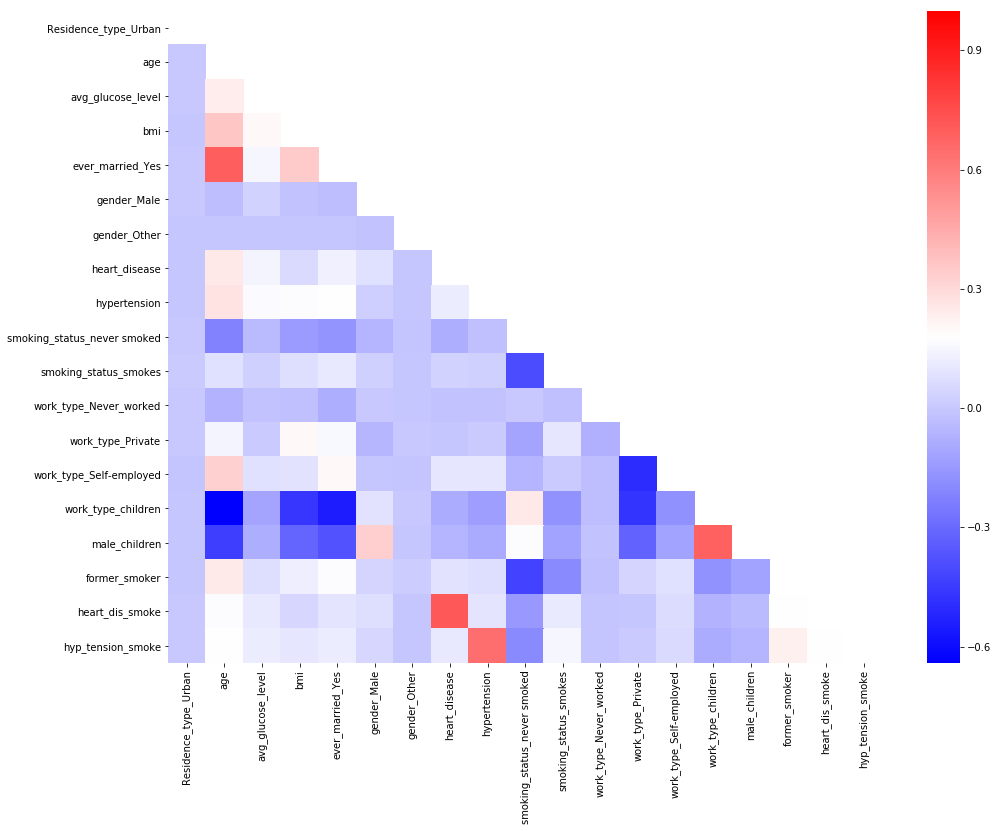

In [38]:
# Plotting correlation for top 10 features
# Ref : https://matplotlib.org/examples/color/colormaps_reference.html for colormap
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(),mask=mask,cmap='bwr')

Intentionally retained the features with correlations. Dropping them has degraded the performance

In [39]:
X.corr()

,Residence_type_Urban,age,avg_glucose_level,bmi,ever_married_Yes,gender_Male,gender_Other,heart_disease,hypertension,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,male_children,former_smoker,heart_dis_smoke,hyp_tension_smoke
Residence_type_Urban,1.000000,0.001299,0.000014,-0.003862,0.004422,0.001606,-0.001489,-0.002743,-0.003124,0.001455,0.008687,0.003089,0.006050,-0.007136,-0.001578,-0.003468,-0.004288,0.001369,0.001558
age,0.001299,1.000000,0.237627,0.363082,0.693070,-0.027603,-0.005168,0.250188,0.272169,-0.223698,0.080043,-0.069509,0.143657,0.326913,-0.641240,-0.442173,0.244646,0.172573,0.176734
avg_glucose_level,0.000014,0.237627,1.000000,0.198719,0.153607,0.035888,-0.005841,0.146938,0.160211,-0.043739,0.025871,-0.014516,0.008048,0.080246,-0.114174,-0.080494,0.075054,0.103088,0.115329
bmi,-0.003862,0.363082,0.198719,1.000000,0.346442,-0.019329,-0.000743,0.060838,0.167431,-0.145446,0.073272,-0.022161,0.203610,0.084546,-0.463475,-0.318025,0.123043,0.045021,0.097867
ever_married_Yes,0.004422,0.693070,0.153607,0.346442,1.000000,-0.030982,-0.006290,0.128833,0.176575,-0.165958,0.104869,-0.080734,0.158857,0.199305,-0.546495,-0.377778,0.172053,0.095895,0.116245
gender_Male,0.001606,-0.027603,0.035888,-0.019329,-0.030982,1.000000,-0.013229,0.082393,0.024070,-0.059348,0.026192,0.002733,-0.052100,-0.002732,0.089076,0.338263,0.038444,0.076460,0.045163
gender_Other,-0.001489,-0.005168,-0.005841,-0.000743,-0.006290,-0.013229,1.000000,-0.003556,-0.005116,-0.009151,-0.002680,-0.001019,0.002065,-0.006859,0.001824,-0.004475,0.015706,-0.002536,-0.003293
heart_disease,-0.002743,0.250188,0.146938,0.060838,0.128833,0.082393,-0.003556,1.000000,0.119777,-0.077985,0.034839,-0.014292,-0.006327,0.099342,-0.089559,-0.061105,0.083395,0.713229,0.105641
hypertension,-0.003124,0.272169,0.160211,0.167431,0.176575,0.024070,-0.005116,0.119777,1.000000,-0.024425,0.026940,-0.019319,0.007236,0.100243,-0.130171,-0.089994,0.071775,0.090399,0.643656
smoking_status_never smoked,0.001455,-0.223698,-0.043739,-0.145446,-0.165958,-0.059348,-0.009151,-0.077985,-0.024425,1.000000,-0.396347,0.001489,-0.110559,-0.060403,0.253599,0.167558,-0.428987,-0.149591,-0.194207


Percentage Variance: [3.486e+01 1.726e+01 1.348e+01 6.200e+00 5.760e+00 5.000e+00 4.660e+00
 3.200e+00 2.120e+00 1.950e+00 1.660e+00 1.120e+00 9.800e-01 8.000e-01
 3.900e-01 3.200e-01 1.600e-01 8.000e-02 1.000e-02]


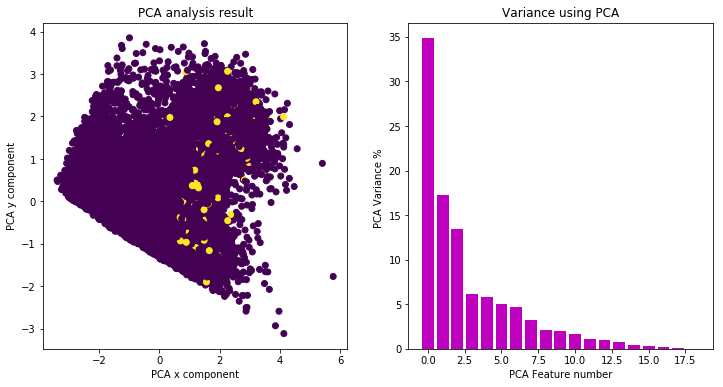

In [40]:
# We will reduce all features to 2D by PCA.
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(12,6))
pca = PCA()
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
fig.add_subplot(1,2,1)
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")
fig.add_subplot(1,2,2)
_ = plt.bar(np.arange(pca.n_components_),100*np.round(pca.explained_variance_ratio_,4),color='m')
_ = plt.xlabel("PCA Feature number")
_ = plt.ylabel("PCA Variance % ")
_ = plt.title('Variance using PCA')
print("Percentage Variance:",100*np.round(pca.explained_variance_ratio_,4))

Elbow appears to be at 3 features. Upto 7 features have non-negligible information.

BEST {'C': 0.1} 0.851710836620765 [mean: 0.84928, std: 0.01180, params: {'C': 0.001}, mean: 0.85169, std: 0.01008, params: {'C': 0.01}, mean: 0.85171, std: 0.00979, params: {'C': 0.1}, mean: 0.85158, std: 0.00972, params: {'C': 1}, mean: 0.85157, std: 0.00972, params: {'C': 10}]
############# LogReg ################
Accuracy on training data: 74.29%
Accuracy on test data:     72.79%
confusion_matrix on dev data
[[6194 2329]
 [  33  124]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      8523
          1       0.05      0.79      0.10       157

avg / total       0.98      0.73      0.83      8680

########################################################


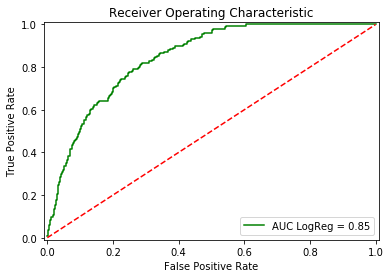

In [41]:
Xtrain, Xdev, ytrain,ydev = train_test_split(X,y,test_size=0.2,stratify=y)
parameters = {"C": [0.001,0.01,0.1,1,10]}
logreg  = do_classify(LogisticRegression(C=0.1,class_weight='balanced'), parameters, Xtrain,ytrain,Xdev,ydev, score_func='roc_auc', n_folds=5, n_jobs=2,label=1,prob_dec=1)

In [42]:
submit_data = data.iloc[train.shape[0]:,:]
print(submit_data.info())
submit_data[['age','avg_glucose_level', 'bmi']] = submit_data[['age','avg_glucose_level', 'bmi']].transform(lambda x: (x - x.mean()) / x.std())
ypred = logreg.predict_proba(submit_data.drop('id',axis=1))
submit_data = submit_data.assign(stroke = ypred[:,1])
submit_data[['id','stroke']].to_csv('aparna_submit.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18601 entries, 0 to 18600
Data columns (total 20 columns):
Residence_type_Urban           18601 non-null uint8
age                            18601 non-null float64
avg_glucose_level              18601 non-null float64
bmi                            18601 non-null float64
ever_married_Yes               18601 non-null uint8
gender_Male                    18601 non-null uint8
gender_Other                   18601 non-null uint8
heart_disease                  18601 non-null int64
hypertension                   18601 non-null int64
id                             18601 non-null int64
smoking_status_never smoked    18601 non-null uint8
smoking_status_smokes          18601 non-null uint8
work_type_Never_worked         18601 non-null uint8
work_type_Private              18601 non-null uint8
work_type_Self-employed        18601 non-null uint8
work_type_children             18601 non-null uint8
male_children                  18601 non-null uint8
f

C:\Users\Aparn\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### CrossChecking by seeing distributions

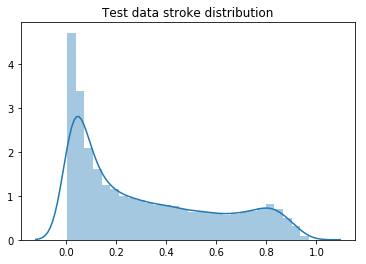

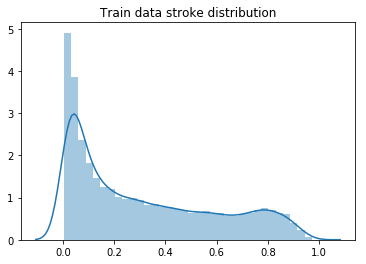

In [43]:
_ = sns.distplot(ypred[:,1])
_ = plt.title('Test data stroke distribution')
_ = plt.figure()
_ = train_pr = logreg.predict_proba(Xtrain)
_ = sns.distplot(train_pr[:,1])
_ = plt.title('Train data stroke distribution')

,Coeff value
age,1.681
male_children,-1.270
work_type_children,0.719
heart_disease,0.613
hypertension,0.426
work_type_Never_worked,-0.243
work_type_Self-employed,0.238
work_type_Private,0.224
gender_Male,0.191
smoking_status_never smoked,-0.190


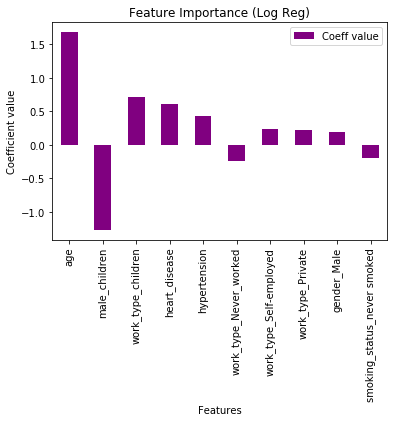

In [44]:
coeff=logreg.coef_
intercept = logreg.intercept_
coeffs_b= logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names_b = list(X.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
logfimp = pd.DataFrame(np.round(coeffs_b,3),index=names_b,columns=['Coeff value'])
_ = logfimp.head(10).plot.bar(color='purple')
_ = plt.title('Feature Importance (Log Reg)')
_ = plt.ylabel('Coefficient value')
_ = plt.xlabel('Features')
logfimp

**The number of features with high feature importance agrees with the findings of PCA**

**Interpretation of Coefficients:** When there is multicollinearity, interpretation is not always exact and reliable, but in this case, age is clearly a dominating feature and related to only 2 other features. Hence I will just give an example of interpretation.          
p(x) = 1/(1+e(-theta(x))), where theta(x) = intercept + coeff_age \* age + coeff_heart_disease \* heart_disease + ......
For a moment, suppose all others are zero, including intercept.
p(x) = 1/(1+e(-coeff_age \* age)), As age increases, exp factor decreases and probability increases. But the amount of increase is dependent on age and hence we can only quantify it at a given age. 
As proven medically and also seen with EDA, we note that in the stroke group, there are high number of aged people. Hence Logistic regression would model this age factor better than any other model.

############# RandomForest ################
Accuracy on training data: 98.20%
Accuracy on test data:     98.19%
confusion_matrix on dev data
[[8523    0]
 [ 157    0]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      8523
          1       0.00      0.00      0.00       157

avg / total       0.96      0.98      0.97      8680

########################################################
Wall time: 19.4 s


C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


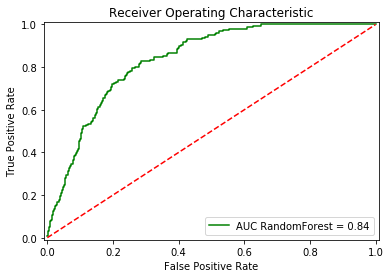

In [45]:
%%time
parameters = {"max_depth": [6,8,12,None], 'min_samples_leaf': [2,4,6],"n_estimators":[10,50,100],"class_weight":['balanced']}
rf = do_classify(RandomForestClassifier(max_depth=12,min_samples_leaf=4,max_features=10,n_estimators=500), None, Xtrain,ytrain,Xdev,ydev, score_func='roc_auc', n_folds=5, n_jobs=2,model_name='RandomForest',label=1,prob_dec=1)

**Remark:** The accuracy numbers are deceptive between Random Forest and Logistic Regression. Recall on positive class is 0 in RF! **Definitely LogReg is a better classifier.**

,Feature importance
avg_glucose_level,0.303836
bmi,0.257598
age,0.219127
Residence_type_Urban,0.030467
gender_Male,0.025869
heart_disease,0.024401
work_type_Private,0.020404
smoking_status_never smoked,0.019731
work_type_Self-employed,0.019413
hypertension,0.019055


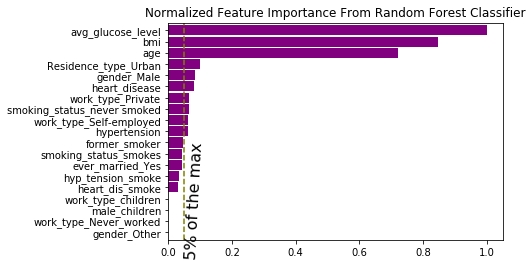

In [46]:
feature_labels = np.array(list(Xtrain.columns))
(pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(rf.feature_importances_)).plot.barh(color='purple',width=0.9)
_ = plt.title('Normalized Feature Importance From Random Forest Classifier')
_ = plt.axvline(0.05,linestyle='--',color='olive')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)
pd.DataFrame(rf.feature_importances_,index=feature_labels,columns=['Feature importance']).sort_values('Feature importance',ascending=False)

**The number of features with high feature importance agrees with the findings of PCA**

In [47]:
ypred = rf.predict_proba(submit_data.drop(['id','stroke'],axis=1))
submit_data = submit_data.assign(stroke = ypred[:,1])
submit_data[['id','stroke']].to_csv('aparna_submit_rf.csv',index=False)

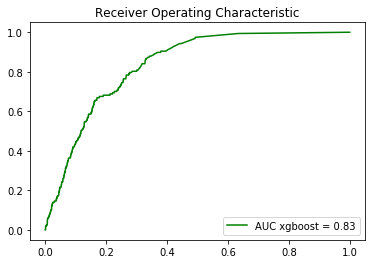

In [48]:
#Try extreme gradient boosting
income_matrix = xgb.DMatrix(Xtrain,ytrain)
params = {"objective":"binary:logistic","max_depth":7,'eta':1, 'silent':1,'eval_metric':'auc','learning_rate':.05}
cv_results = xgb.cv(dtrain=income_matrix,params=params,nfold=4,num_boost_round=50,metrics="auc",as_pandas=True)
trained_xgb = xgb.train(params,income_matrix,num_boost_round=50)
ypred_xgb=trained_xgb.predict(xgb.DMatrix(Xdev))
ypred_xgb_bin = ypred_xgb > 0.5
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, ypred_xgb,pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,'g' ,label='AUC '+"xgboost"+' = %0.2f'% roc_auc)
plt.legend(loc='lower right')

In [49]:
ypred = trained_xgb.predict(xgb.DMatrix(submit_data.drop(['id','stroke'],axis=1)))
submit_data = submit_data.assign(stroke = ypred)
submit_data[['id','stroke']].to_csv('aparna_submit_xgb.csv',index=False)

### What did I do well

+ Took constant breaks and thought about the problem on and off rather than spending all my time in front of computer
+ I am in US Pacific time zone. Contest started at 5pm for me, and I slept by 10pm, got up around 7am. Started working again at 9am after having relaxed breakfast and family time. My final solution was the one submitted within the first 5 hours, just with more comments and detailed EDA. I literally applied the lesson learnt from first hackathon: Having enough rest is the most important factor to do well.

As for the approach:      
+ Got into getting domain knowledge immediately. First read mayoclinic article which is the most trustworthy one and then researched a bit on those factors not mentioned there. Mayoclinic post was useful, others were not super useful, but it is better to have the confidence of exploring enough.
+ Tried a commonsense baseline (not shown in the notebook), of predicting the probabilities based solely on aggregate based on age. Luckily test set did not have a new age number, or else this was not easy. This itself gave AUC number 0.81+, hence I got a reference.
+ Used linear regression to fill missing bmi. Imputing with mean and median changed the distribution.
+ Substituted smoking status of children below 10 by  never smoked (as they were all unknown)
+ Tried logistic regression with 5 fold CV and hyperparameters all at once. Kept a dev set which was not part of this 5 fold cross validation. 
+ Found that BMI did not show much difference, but kept it, as it is an indicator of obesity and medically the weight is very big determinant of stroke probability
+ Did some age rangewise EDA, got some intuition
+ Plotted PCA, feature importance and did all kinds of cross verification.

**Finally I felt accomplished despite getting a public score of 0.829 and 182nd rank, because I approached this like a Data Scientist. I had a pleasant surprise when private leaderboard score was 0.858 and position was 22nd!!!**


### Methods that did not work:

+ Tried kNN with several neighbors option, gave only about 0.71
+ Tried SVM, even though classes were not separable. SVM would generally work when classes are well separated. Still wanted to crosscheck. As expected, ROC curve was not even convex. It was having crazy random pattern around the straight line joining  (0,0) and (1,1)
+ The scale of probabilities found with xgboost and logistic regressions were different. First brought them to same scale and then applied some weightage, 0.6logreg_prob + 0.4xgboost_prob to find the weighted probabilities and checked the score. It did not improve the score on public leaderboard. Hence did not want to risk with a method which is not logically convincing. Besides there is no straightforward equivalent option of class_weight argument that is present in logreg and Random Forest. This is absent even in gradient boosting algorithm which is the mother of extreme gradient boosting

### What I could have done better:
+ Should have paid more attention to leverage points (points which are far away from mean - they are outliers among features) and removed those which are not present in test data.
+ Should have filled those remaining 20% smoking status. (did only for the children, which was around 10% out of 30% missing)
+ Should have taken some risks and gone with my gut feeling and analysis (a)of dropping irrelevant feature like residence type and b) assigning weights to smoking status instead of one hot encoding - top 2 among many) even though it gave slightly less score in public LB. After all I was doing this to gain more experience and not for the rank. But it is hard to do!Especially when rank matters to put in your resume
+ Could have done binning on age, average glucose level (thought about these but didnt even try)
+ Read about catboost recently, but did not try. It was worth trying because many others tried it and got good results.
+ One thing that never occured to me is trying xgboost with linear base learner.
+ Should have tried combining results from random forest and logreg in a sensible way. I only tried with xgboost
+ Could have tried L1 penalty too on log reg, it would have automatically dropped irrelevent features
+ Never tried hyperparameter tuning on xgboost. Since logreg gave good results, xgboost seemed like overkill and I still feel I am right. This is something that I am yet to understand. Everyone seems excited about using it even though logistic regression can do the same job.

### Why did I not try Sampling methods or SMOTE

+ I did read SMOTE paper a few days ago and I get the idea. They recommend using it along with undersampling majority class.
+ I am not convinced that it is widely practiced in industry. I am not sure of its usefulness to the current problem. Did not prioritize it over other things and studied when it should be applied.
+ When I don't have clarity, I am not comfortable using it just because it could give results. There is a package imblearn and I was surprised recently that one of the practicing data scientists heard about it from me.
+ One more experienced data scientist (PhD, > 5 yrs experience) indicated that whenever possible, she would try not to use these methods, and try to keep train and test distributions same.
+ My Springboard mentor who is a PhD with 7+ yrs of DS experience did not recommend any of the sampling methods to my moderately imbalanced classification problems (70:15:15 - 3 class problem) and said that these methods bias the model. Unless we are dealing with huge imbalance like < 1% positive labels we may not want to use it, especially when there are enough number of positive labels to learn from. 
+ I think ratio of number of features Vs number of samples matters. With lower number of features, that too very few numerical features, SMOTE can not generate too many different new samples. After all, it is some weighted combination of other samples of positive labels. Hence I have my own doubts of its usefulness in the current problem.

Please feel free to comment here and follow me on twitter @aparsha2303 for quick updates on my work.